<a href="https://colab.research.google.com/github/Userfound404/GSoC-QMLHEP-Tasks/blob/main/QMLHEP_GSoC'24_Task_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane pennylane-qiskit


In [ ]:
import torch
from torchvision import transforms, datasets
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)


In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:
def q_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(4))
    qml.templates.StronglyEntanglingLayers(params, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]


In [ ]:
def swap_test_circuit(params, x1, x2):
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0, 1, 2])
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.CSWAP(wires=[0, 1, 2])
    qml.Hadamard(wires=0)
    return qml.expval(pl.PauliZ(0))


In [ ]:
def contrastive_loss(y_true, y_pred, margin=1):
    loss = y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred)
    return tf.reduce_mean(loss)


In [ ]:
device = qml.device("default.qubit", wires=4)

@qml.qnode(device, interface="tf")
def quantum_model(inputs, params):
    return q_circuit(params, inputs)

@qml.qnode(device, interface="tf")
def swap_test(inputs_1, inputs_2, params):
    return swap_test_circuit(params, inputs_1, inputs_2)


In [ ]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30
n_wires = 4

In [ ]:
def MyModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = MyModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1))

# Initialize quantum model
params = np.random.normal(loc=0, scale=0.1, size=(n_layers, n_wires))
q_model = MyModel()

# Train quantum model
q_history_old = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)




Epoch 1/10


15000/15000 - 26s - loss: 0.1958 - accuracy: 0.9412 - val_loss: 0.1143 - val_accuracy: 0.9656 - 26s/epoch - 2ms/step
Epoch 2/10
15000/15000 - 24s - loss: 0.0947 - accuracy: 0.9716 - val_loss: 0.1001 - val_accuracy: 0.9702 - 24s/epoch - 2ms/step
Epoch 3/10
15000/15000 - 24s - loss: 0.0689 - accuracy: 0.9783 - val_loss: 0.0928 - val_accuracy: 0.9728 - 24s/epoch - 2ms/step
Epoch 4/10
15000/15000 - 24s - loss: 0.0573 - accuracy: 0.9820 - val_loss: 0.1040 - val_accuracy: 0.9714 - 24s/epoch - 2ms/step
Epoch 5/10
15000/15000 - 24s - loss: 0.0457 - accuracy: 0.9857 - val_loss: 0.0995 - val_accuracy: 0.9769 - 24s/epoch - 2ms/step
Epoch 6/10
15000/15000 - 24s - loss: 0.0391 - accuracy: 0.9881 - val_loss: 0.1046 - val_accuracy: 0.9753 - 24s/epoch - 2ms/step
Epoch 7/10
15000/15000 - 25s - loss: 0.0337 - accuracy: 0.9896 - val_loss: 0.1018 - val_accuracy: 0.9773 - 25s/epoch - 2ms/step
Epoch 8/10
15000/15000 - 24s - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.1240 - val_accuracy: 0.

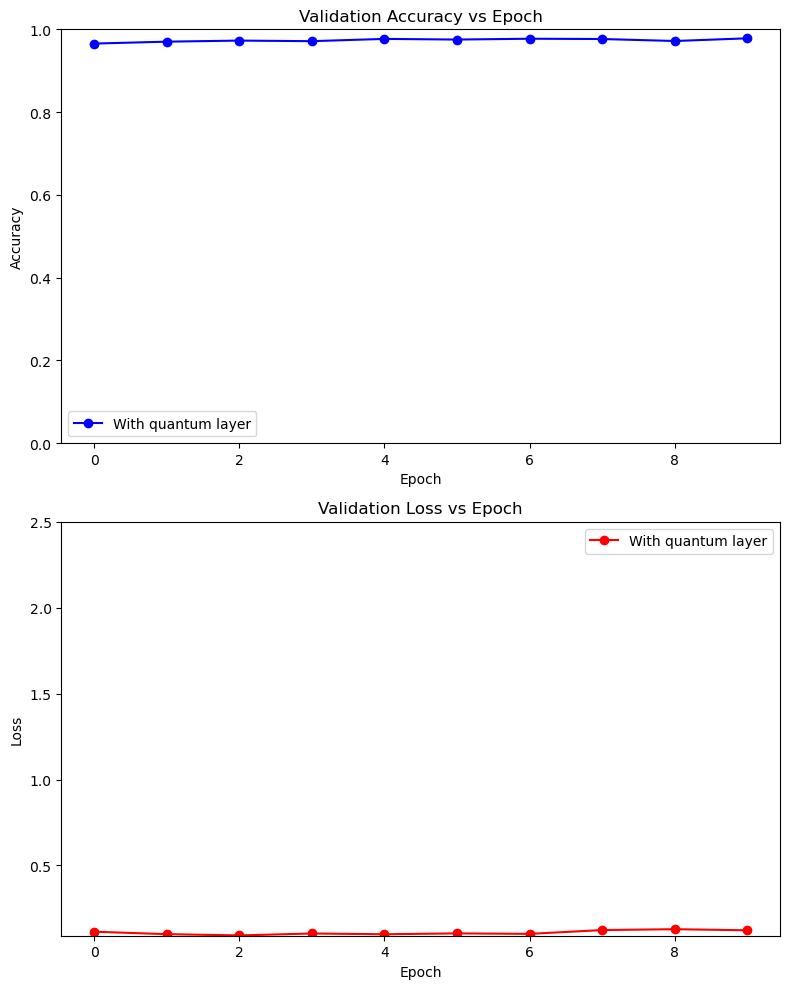

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot validation accuracy
ax1.plot(q_history_old.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Validation Accuracy vs Epoch")

# Plot validation loss
ax2.plot(q_history_old.history["val_loss"], "-or", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Validation Loss vs Epoch")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 118ms/step


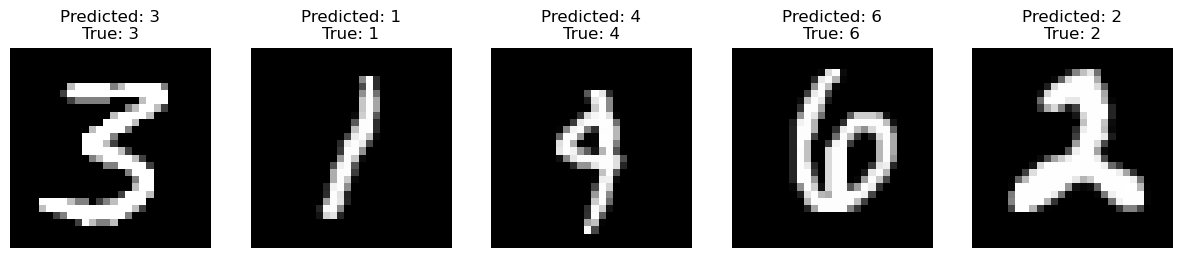

In [ ]:
# Choose some random test images
num_images_to_test = 5
random_indices = np.random.choice(len(x_test), size=num_images_to_test, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Predict using the quantum model
predictions = q_model.predict(test_images)

# Visualize the images along with their predicted labels
plt.figure(figsize=(15, 3))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Predicted: {np.argmax(predictions[i])}\nTrue: {test_labels[i]}")
    plt.axis('off')
plt.show()


In [ ]:
# Increase the number of layers in the quantum circuit
n_layers = 3

# Reinitialize parameters
params = np.random.normal(loc=0, scale=0.1, size=(n_layers, n_wires))

# Initialize and train quantum model
q_model = MyModel()

q_history = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)


Epoch 1/10
15000/15000 - 27s - loss: 0.2042 - accuracy: 0.9385 - val_loss: 0.1128 - val_accuracy: 0.9651 - 27s/epoch - 2ms/step
Epoch 2/10
15000/15000 - 27s - loss: 0.0963 - accuracy: 0.9717 - val_loss: 0.0918 - val_accuracy: 0.9711 - 27s/epoch - 2ms/step
Epoch 3/10
15000/15000 - 26s - loss: 0.0708 - accuracy: 0.9777 - val_loss: 0.1106 - val_accuracy: 0.9684 - 26s/epoch - 2ms/step
Epoch 4/10
15000/15000 - 26s - loss: 0.0551 - accuracy: 0.9833 - val_loss: 0.0963 - val_accuracy: 0.9735 - 26s/epoch - 2ms/step
Epoch 5/10
15000/15000 - 25s - loss: 0.0469 - accuracy: 0.9856 - val_loss: 0.1071 - val_accuracy: 0.9725 - 25s/epoch - 2ms/step
Epoch 6/10
15000/15000 - 28s - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0960 - val_accuracy: 0.9772 - 28s/epoch - 2ms/step
Epoch 7/10
15000/15000 - 25s - loss: 0.0355 - accuracy: 0.9888 - val_loss: 0.1074 - val_accuracy: 0.9767 - 25s/epoch - 2ms/step
Epoch 8/10
15000/15000 - 25s - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.1254 - val_accuracy: 0.9758

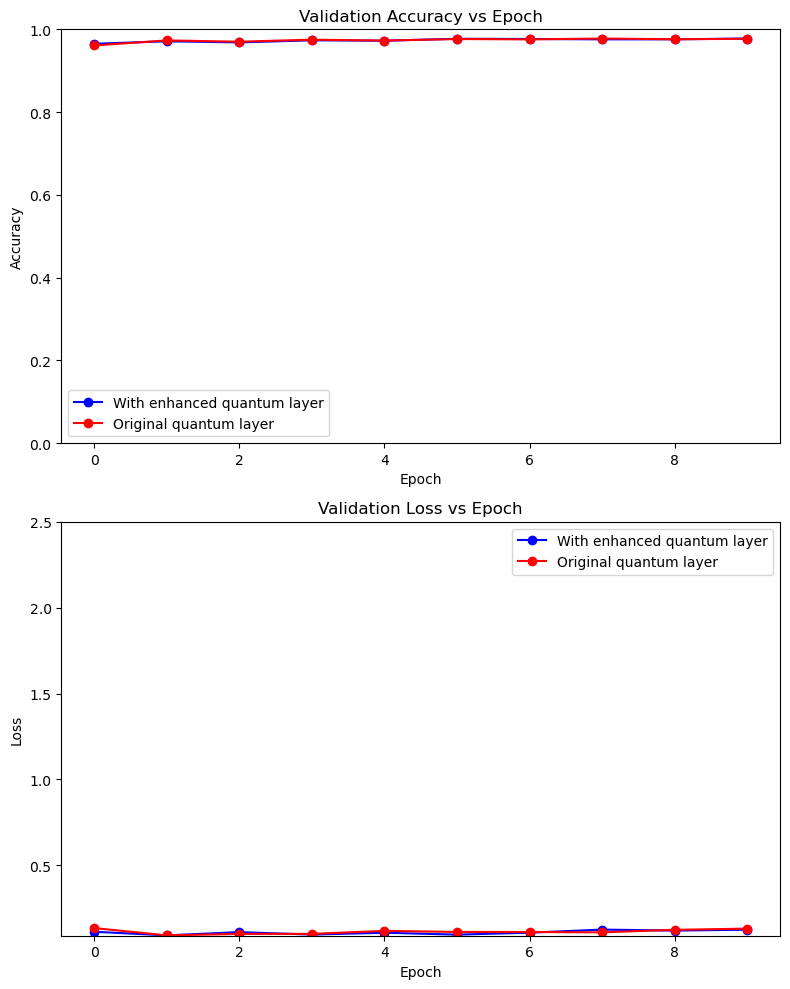

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot validation accuracy
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With enhanced quantum layer")
ax1.plot(q_history_old.history["val_accuracy"], "-or", label="Original quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Validation Accuracy vs Epoch")

# Plot validation loss
ax2.plot(q_history.history["val_loss"], "-ob", label="With enhanced quantum layer")
ax2.plot(q_history_old.history["val_loss"], "-or", label="Original quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Validation Loss vs Epoch")

plt.tight_layout()
plt.show()


In [ ]:
# Reshape images to match the number of qubits
x_train_reshaped = np.expand_dims(x_train, axis=-1)
x_test_reshaped = np.expand_dims(x_test, axis=-1)

# Prepare quantum inputs
quantum_inputs_train = x_train_reshaped[:n_train]
quantum_inputs_test = x_test_reshaped[:n_test]

# Prepare classical inputs
classical_inputs_train = classical_model.predict(x_train_reshaped[:n_train])
classical_inputs_test = classical_model.predict(x_test_reshaped[:n_test])


1/1 [==============================] - 0s 29ms/step


In [ ]:
# Reshape quantum inputs to remove the extra dimension
quantum_inputs_train = np.reshape(quantum_inputs_train, (n_train, -1))
quantum_inputs_test = np.reshape(quantum_inputs_test, (n_test, -1))

In [ ]:
# Concatenate classical and quantum inputs
hybrid_inputs_train = tf.concat([classical_inputs_train, quantum_inputs_train], axis=1)
hybrid_inputs_test = tf.concat([classical_inputs_test, quantum_inputs_test], axis=1)

# Define hybrid model
hybrid_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile hybrid model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(hybrid_inputs_train, y_train[:n_train],
                            validation_data=(hybrid_inputs_test, y_test[:n_test]),
                            epochs=10, batch_size=32, verbose=2)


Epoch 1/10
2/2 - 1s - loss: 2.3608 - accuracy: 0.1200 - val_loss: 2.2567 - val_accuracy: 0.1667 - 1s/epoch - 557ms/step
Epoch 2/10
2/2 - 0s - loss: 2.1478 - accuracy: 0.2600 - val_loss: 2.1660 - val_accuracy: 0.2000 - 41ms/epoch - 21ms/step
Epoch 3/10
2/2 - 0s - loss: 1.9673 - accuracy: 0.4400 - val_loss: 2.0866 - val_accuracy: 0.2667 - 43ms/epoch - 22ms/step
Epoch 4/10
2/2 - 0s - loss: 1.8231 - accuracy: 0.6200 - val_loss: 2.0073 - val_accuracy: 0.4333 - 41ms/epoch - 20ms/step
Epoch 5/10
2/2 - 0s - loss: 1.6765 - accuracy: 0.7000 - val_loss: 1.9298 - val_accuracy: 0.4667 - 42ms/epoch - 21ms/step
Epoch 6/10
2/2 - 0s - loss: 1.5438 - accuracy: 0.7200 - val_loss: 1.8628 - val_accuracy: 0.5000 - 40ms/epoch - 20ms/step
Epoch 7/10
2/2 - 0s - loss: 1.4178 - accuracy: 0.7800 - val_loss: 1.8001 - val_accuracy: 0.5000 - 41ms/epoch - 21ms/step
Epoch 8/10
2/2 - 0s - loss: 1.2986 - accuracy: 0.7800 - val_loss: 1.7345 - val_accuracy: 0.5000 - 43ms/epoch - 21ms/step
Epoch 9/10
2/2 - 0s - loss: 1.187

In [ ]:
# Concatenate classical and quantum inputs
hybrid_inputs_train = tf.concat([classical_inputs_train, quantum_inputs_train], axis=1)
hybrid_inputs_test = tf.concat([classical_inputs_test, quantum_inputs_test], axis=1)

# Define hybrid model
hybrid_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile hybrid model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(hybrid_inputs_train, y_train[:n_train],
                            validation_data=(hybrid_inputs_test, y_test[:n_test]),
                            epochs=10, batch_size=32, verbose=2)


Epoch 1/10
2/2 - 1s - loss: 2.4195 - accuracy: 0.1000 - val_loss: 2.3276 - val_accuracy: 0.1667 - 1s/epoch - 642ms/step
Epoch 2/10
2/2 - 0s - loss: 2.1415 - accuracy: 0.2200 - val_loss: 2.2700 - val_accuracy: 0.1667 - 47ms/epoch - 23ms/step
Epoch 3/10
2/2 - 0s - loss: 1.9208 - accuracy: 0.3800 - val_loss: 2.2110 - val_accuracy: 0.2000 - 47ms/epoch - 23ms/step
Epoch 4/10
2/2 - 0s - loss: 1.7515 - accuracy: 0.6000 - val_loss: 2.1366 - val_accuracy: 0.2667 - 49ms/epoch - 24ms/step
Epoch 5/10
2/2 - 0s - loss: 1.5837 - accuracy: 0.6600 - val_loss: 2.0573 - val_accuracy: 0.2667 - 47ms/epoch - 24ms/step
Epoch 6/10
2/2 - 0s - loss: 1.4279 - accuracy: 0.7000 - val_loss: 1.9789 - val_accuracy: 0.3333 - 46ms/epoch - 23ms/step
Epoch 7/10
2/2 - 0s - loss: 1.2848 - accuracy: 0.7600 - val_loss: 1.9033 - val_accuracy: 0.3667 - 48ms/epoch - 24ms/step
Epoch 8/10
2/2 - 0s - loss: 1.1528 - accuracy: 0.7800 - val_loss: 1.8226 - val_accuracy: 0.4000 - 47ms/epoch - 24ms/step
Epoch 9/10
2/2 - 0s - loss: 1.033